In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import Input, Dense, Activation, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import random
tf.compat.v1.set_random_seed(0)
sess_config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads = 1,inter_op_parallelism_threads = 1)
sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = sess_config)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
train_data_dir = '#########/train'
val_data_dir = '########/val'
test_data_vir = '########/test'

# Loading and Pre-processing Train and Validation data

In [ ]:
train_gen = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)
train_generator = train_gen.flow_from_directory(batch_size = 16, 
                                                directory= train_data_dir, 
                                                shuffle = True, 
                                                target_size = (256, 256), 
                                                class_mode = 'categorical',    
                                                seed = 0)

Found 212 images belonging to 4 classes.


In [ ]:
val_gen = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)
val_generator = val_gen.flow_from_directory(batch_size = 16, 
                                                     directory= val_data_dir, 
                                                     shuffle = True, 
                                                     target_size = (256, 256), 
                                                     class_mode = 'categorical',
                                                     seed = 0)

Found 56 images belonging to 4 classes.


In [ ]:
train_images, train_labels = next(train_generator)

In [ ]:
train_images.shape

(16, 256, 256, 3)

In [ ]:
train_labels.shape

(16, 4)

In [ ]:
labels = {0: 'Covid19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

### Data visualization

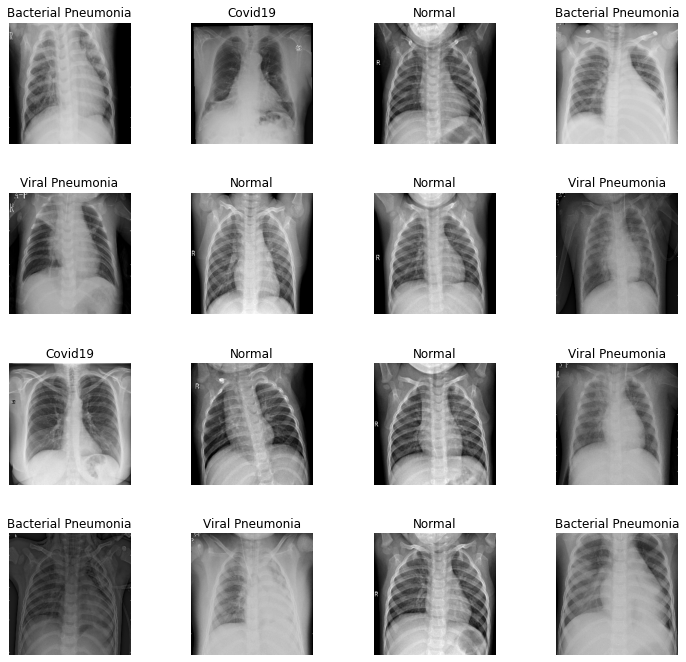

In [ ]:
l = 4
w = 4
fig, axes = plt.subplots(l, w, figsize = (12, 12))
axes = axes.ravel() 
for i in np.arange(0, l*w):
    axes[i].imshow(train_images[i])
    axes[i].set_title(labels[np.argmax(train_labels[i])])
    axes[i].axis('off')
    
plt.subplots_adjust(wspace = 0.5)

Importing a pre-trained InceptionV3 model, trained on imagenet dataset.

In [ ]:
basemodel = InceptionV3(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))
basemodel.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________

Fine tuning the layers

In [ ]:
for layer in basemodel.layers[:-5]:
    layer.trainable = False

In [ ]:
m = basemodel.output
m = AveragePooling2D(pool_size = (4,4))(m)

m = Flatten(name= 'flatten')(m)

m = Dense(256, activation = "relu")(m)
m = Dropout(0.4)(m)

m = Dense(128, activation = "relu")(m)
m = Dropout(0.4)(m)

m = Dense(64, activation = "relu")(m)
m = Dropout(0.4)(m)

m = Dense(4, activation = 'softmax')(m)

model = Model(inputs = basemodel.input, outputs = m)

# Model Training

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(), metrics = ['accuracy'])

In [ ]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10)
checkpointer = ModelCheckpoint(filepath = 'weights.hdfs', verbose = 1, save_best_only=True)

In [ ]:
train_generator.n, val_generator.n 

(212, 56)

In [ ]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch= train_generator.n //16, 
                              epochs = 50, 
                              validation_data= val_generator, 
                              validation_steps= val_generator.n //16, 
                              callbacks=[checkpointer, earlystopping])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
13/13 [==============================] - 35s 2s/step - loss: 2.0059 - accuracy: 0.2344 - val_loss: 1.3098 - val_accuracy: 0.3125

Epoch 00001: val_loss improved from inf to 1.30979, saving model to weights.hdfs
INFO:tensorflow:Assets written to: weights.hdfs/assets
Epoch 2/50
13/13 [==============================] - 28s 2s/step - loss: 1.6961 - accuracy: 0.3481 - val_loss: 1.2606 - val_accuracy: 0.3542

Epoch 00002: val_loss improved from 1.30979 to 1.26060, saving model to weights.hdfs
INFO:tensorflow:Assets written to: weights.hdfs/assets
Epoch 3/50
13/13 [==============================] - 28s 2s/step - loss: 1.4972 - accuracy: 0.3400 - val_loss: 1.1747 - val_accuracy: 0.5000

Epoch 00003: val_loss improved from 1.26060 to 1.17473, saving model to weights.hdfs
INFO:tensorflow:Assets written to: weights.hdfs/assets
Epoch 4/50
13/13 [==============================] - 28s 2s/step - loss: 1.1977 - accuracy: 0.4209 - val_loss: 1.0941 - val_accuracy: 0.5208

Epoch 00004: val_los

In [ ]:
model.save('Inception.h5')

##Model evaluation

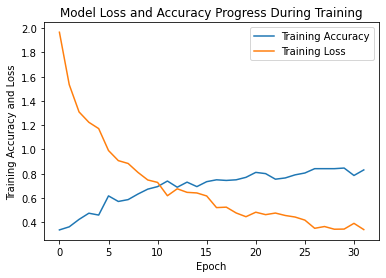

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

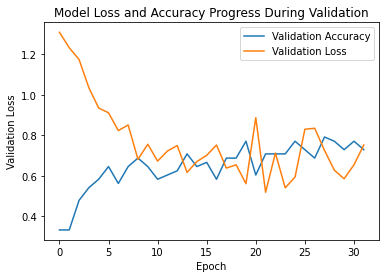

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss and Accuracy Progress During Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Accuracy', 'Validation Loss'])

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(batch_size = 4, 
                                             directory = test_data_vir, 
                                             shuffle = True,
                                             target_size = (256, 256),
                                              class_mode = 'categorical',
                                              seed = 0)

Found 36 images belonging to 4 classes.


In [ ]:
model = load_model('#######/Inception.h5')
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n//2, verbose = 1)

In [ ]:
print('Accuracy during test: {}'.format(evaluate[1]))

Accuracy during test: 0.7222222089767456


# Model Prediction

In [ ]:
prediction = []
original = []
image = []
for i in os.listdir(test_data_vir):
  for item in os.listdir(os.path.join(test_data_vir,i)):
    img= cv2.imread(os.path.join(test_data_vir,i,item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(labels[int(predict)])
    if(i=='covid'):
      original.append('Covid19')
    elif(i=='normal'):
      original.append('Normal')
    elif(i=='pneumonia_bac'):
      original.append('Bacterial Pneumonia')
    else:
      original.append('Viral Pneumonia')

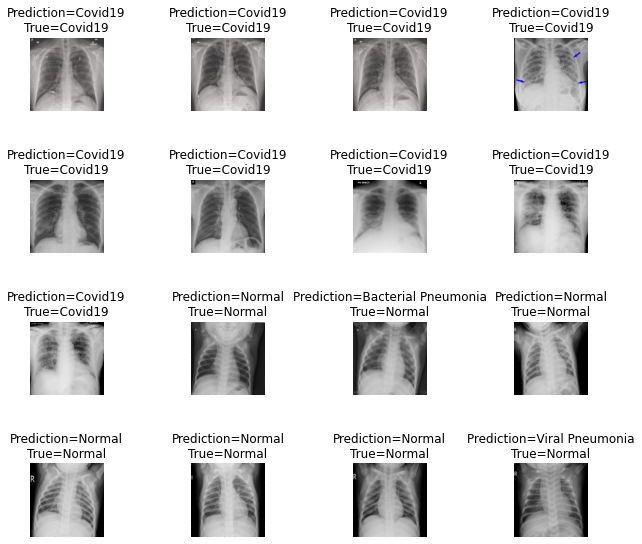

In [ ]:
L = 4
W = 4

fig, axes = plt.subplots(L, W, figsize = (10, 10))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Prediction={}\nTrue={}'.format(prediction[i], original[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

Text(33.0, 0.5, 'Original')

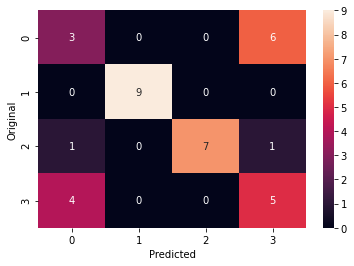

In [ ]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')